In [52]:
import pandas as pd
import os,sys
import numpy as np
import multiprocessing as mp
import matplotlib.pyplot as plt
cpus = int(np.floor(mp.cpu_count()/2)-1)
print(cpus)

os.chdir('/data/jake/gene-fusion/python')

35


## GRCh37 Gene list

Genes were partitioned by chr-strand with ipython

In [36]:
# full file
df = pd.read_csv('../data/Homo_sapiens.GRCh37.82.chr.genes.bed',sep='\t',header=None)
## drop '.' column
df = df.drop(df.columns[4],axis=1)
df.columns = df.columns = ['chr', 'start', 'end', 'gene', 'strand']
df.head()

,chr,start,end,gene,strand
0,chr1,69091,70008,OR4F5,+
1,chr1,134901,139379,AL627309.1,-
2,chr1,139790,140339,RP11-34P13.14,-
3,chr1,367640,368634,OR4F29,+
4,chr1,621059,622053,OR4F16,-


In [37]:
# exclude special chr
print('before:',df.chr.unique())
df = df[df['chr'].str.contains('chr\\d|chrX|chrY', regex=True)]
print('after:',df.chr.unique())

before: ['chr1' 'chr10' 'chr11' 'chr12' 'chr13' 'chr14' 'chr15' 'chr16' 'chr17'
 'chr18' 'chr19' 'chr2' 'chr20' 'chr21' 'chr22' 'chr3' 'chr4' 'chr5'
 'chr6' 'chr7' 'chr8' 'chr9' 'chrGL000191.1' 'chrGL000192.1'
 'chrGL000193.1' 'chrGL000194.1' 'chrGL000195.1' 'chrGL000201.1'
 'chrGL000204.1' 'chrGL000205.1' 'chrGL000209.1' 'chrGL000212.1'
 'chrGL000213.1' 'chrGL000215.1' 'chrGL000218.1' 'chrGL000219.1'
 'chrGL000221.1' 'chrGL000222.1' 'chrGL000223.1' 'chrGL000228.1'
 'chrGL000237.1' 'chrGL000242.1' 'chrMT' 'chrX' 'chrY']
after: ['chr1' 'chr10' 'chr11' 'chr12' 'chr13' 'chr14' 'chr15' 'chr16' 'chr17'
 'chr18' 'chr19' 'chr2' 'chr20' 'chr21' 'chr22' 'chr3' 'chr4' 'chr5'
 'chr6' 'chr7' 'chr8' 'chr9' 'chrX' 'chrY']


In [38]:
dir_chr_gene_lists='../data/chr_gene_lists'
groups = [group for _,group in df.groupby(['chr','strand'])]
for d in groups:
    fname = f"{d['chr'].unique()[0]}.{d['strand'].apply(lambda x: 'pos' if x == '+' else 'neg').unique()[0]}"
    d.to_csv(os.path.join(dir_chr_gene_lists,fname),sep='\t',header=False, index=False)


In [59]:
chr21 = pd.read_csv(os.path.join(dir_chr_gene_lists,'chr21.neg'),sep='\t',header=None).head()
chr21.head()

,0,1,2,3,4
0,chr21,10906201,11029719,TPTE,-
1,chr21,14741931,14745386,AL050302.1,-
2,chr21,15051621,15053459,AL050303.1,-
3,chr21,15481134,15583166,LIPI,-
4,chr21,15743436,15755805,HSPA13,-


## Count valid gene pairs


- Beds are left sorted.
- The first gene has n-1 pairs
- The next gene has n-2 pairs
- ...
- The last gene has 0 pairs

 $\sum_{k=1}^{n} = \frac{n(n+1)}{2}$ so $\sum_{k=0}^{n-1}k = \frac{(n-1)((n-1)+1)}{2} = \frac{(n-1)n}{2}$.

In [51]:
pairs = 0
total_genes = 0
files = [os.path.join(dir_chr_gene_lists,f) for f in os.listdir(dir_chr_gene_lists)]
for file in files:
    with open(file, 'r') as f:
        n = sum(1 for line in f)
        pairs += (((n-1) * n) /2)
        total_genes += n
print('total_genes (m):',total_genes)
print('m^2:',total_genes**2)
print('valid pairs:',pairs)


total_genes (m): 26954
m^2: 726518116
valid pairs: 9397382.0


Text(0, 0.5, 'log10')

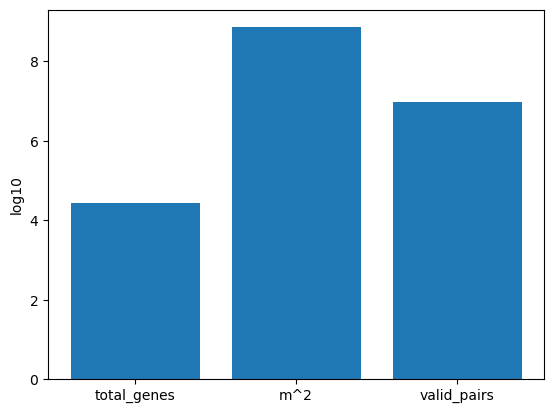

In [58]:
data = [np.log10(x) for x in [total_genes,total_genes**2,pairs]]
plt.bar(['total_genes','m^2','valid_pairs'],data)
plt.ylabel('log10')

## STIX

Will run this in singularity container. Not in notebook

In [ ]:
#stix -i index -d stix.ped.db -t DEL -l $left -r $right -s 500 > out.stix
def stix(index, db, chr, type, left_start, left_end, right_start, right_end, outfile):
    cmd = f"stix -i {index} -d {db} -t {type} -l {chr}:{left_start}-{left_end} -r {chr}:{right_start}-{right_end} > {outfile}"
    print(cmd)
    os.system(cmd)

pseudo code for  chr-strand wise stix queries
```
 open gene_file
 for shard in db:
    for i in range(len(file)):
        read gene_i
        for j in range(i+1,len(file)):
            read gene_j
            stix(shard, gene_i, gene_j)
 aggregate
```

    
# 
while read -r _ r_s r_e gene_j _; do
  echo "#gene_j: $gene_j"
  if [ "$r_s" -gt "$l_e" ]; then
    # verify slop parameter
    stix -i alt_sort_b -d 1kg.ped.db -s 500 -t DEL -l $chr:$l_s-$l_e -r $chr:$r_s-$r_e > $outdir/$gene_i.$gene_j.stix
  else
    echo "#skipping $gene_j (preceeds query)"
  fi
done < $gene_file

In [60]:
chr21

,0,1,2,3,4
0,chr21,10906201,11029719,TPTE,-
1,chr21,14741931,14745386,AL050302.1,-
2,chr21,15051621,15053459,AL050303.1,-
3,chr21,15481134,15583166,LIPI,-
4,chr21,15743436,15755805,HSPA13,-


In [44]:
files[-1]

'../data/chr_gene_lists/chrY.neg'

In [20]:
for i in df.itertuples(index=True):
    print(i.); break

Pandas(Index=0, _1='chr21', _2=10906201, _3=11029719, _4='TPTE', _5='.', _6='neg')


## Stix runner
```
#!/usr/bin/env bash
# for query gene, search for gene fusions; same chr and strand

# ex: stix_runner.sh > stix_runner.log 2>&1

# args
set -u
gene_i=${1:-ERG}
chr=${2:-21}
l_s=${3:-39751949}
l_e=${4:-40033704}
gene_file=${5:-chr21.neg}
outdir=${6:-/data/jake/gene-fusion/tmp}
[ -d "$outdir" ] || { echo "Directory '$outdir' does not exist. Exiting."; exit 1; }
echo "BEGIN"
date
echo -e "#gene: $gene_i\tchr: $chr\tl_s: $l_s\tl_e: $l_e\tgene_file: $gene_file\toutdir: $outdir" 
# query stix with gene_i=left and gene_j:= rows in gene bed file
while read -r _ r_s r_e gene_j _; do
  echo "#gene_j: $gene_j"
  if [ "$r_s" -gt "$l_e" ]; then
    # verify slop parameter
    stix -i alt_sort_b -d 1kg.ped.db -s 500 -t DEL -l $chr:$l_s-$l_e -r $chr:$r_s-$r_e > $outdir/$gene_i.$gene_j.stix
  else
    echo "#skipping $gene_j (preceeds query)"
  fi
done < $gene_file
date
echo "END"

# next:
# perform query for each unique gene,chromosome,strand #!/usr/bin/env bash
# for query gene, search for gene fusions; same chr and strand

# ex: stix_runner.sh > stix_runner.log 2>&1

# args
set -u
gene_i=${1:-ERG}
chr=${2:-21}
l_s=${3:-39751949}
l_e=${4:-40033704}
gene_file=${5:-chr21.neg}
outdir=${6:-/data/jake/gene-fusion/tmp}
[ -d "$outdir" ] || { echo "Directory '$outdir' does not exist. Exiting."; exit 1; }
echo "BEGIN"
date
echo -e "#gene: $gene_i\tchr: $chr\tl_s: $l_s\tl_e: $l_e\tgene_file: $gene_file\toutdir: $outdir" 
# query stix with gene_i=left and gene_j:= rows in gene bed file
while read -r _ r_s r_e gene_j _; do
  echo "#gene_j: $gene_j"
  if [ "$r_s" -gt "$l_e" ]; then
    # verify slop parameter
    stix -i alt_sort_b -d 1kg.ped.db -s 500 -t DEL -l $chr:$l_s-$l_e -r $chr:$r_s-$r_e > $outdir/$gene_i.$gene_j.stix
  else
    echo "#skipping $gene_j (preceeds query)"
  fi
done < $gene_file
date
echo "END"

# next:
# perform query for each unique gene,chromosome,strand 
```

In [ ]:
def 

In [4]:
def agg_gene_fusion(samples, gene_list,pop_label=None):
    A = pd.DataFrame({'samples': range(100)})
    c = range(23)
    # chr
    for i in c:
        n = len(gene_list)
        # gene_left
        for j in range(n):
            strand_j = gene_list[j][3]
            # gene right
            for k in range(j+1,n):
                strand_k = gene_list[k][3]
                if strand_j == strand_k:
                    # stix data
                    df = STIX(i, l , r)
                    # sample
                    for l in range(samples):
                        if df.evidence[l] > 0:
                            A[l,g_i] = df.evidence
               
            

,samples
0,0
1,1
2,2
3,3
4,4
...,...
95,95
96,96
97,97
98,98
